# Idea
Dataset used for prediction: MODIS LCD, MODIS GPP, CLIMATE PRECIPITATION

In [9]:
!unzip -q clipped_dataset.zip

In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 25.1 MB/s eta 0:00:00


In [6]:
import os
import numpy as np
import rasterio
from tensorflow.keras.utils import normalize
import cv2
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ConvLSTM2D, BatchNormalization, Conv2D

In [7]:
modis_lcd = "/content/Datasets_Hackathon/Modis_Land_Cover_Data"
modis_gpp = "/content/Datasets_Hackathon/MODIS_Gross_Primary_Production_GPP"
climate_precip = "/content/Datasets_Hackathon/Climate_Precipitation_Data"
image_size = (769, 565)

# Load, and prepare MODIS LCD images

In [10]:
def load_modis_lcd_images(folder, image_size):
    image_files = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.tif')])
    images = []

    for file in image_files:
        with rasterio.open(file) as src:
            img = src.read(1).astype(np.float32)  # Read first band (grayscale)

            # Mask out -128 values
            mask = img == -128
            img[mask] = np.nan  # Assign NaN to avoid affecting normalization

            # Resize image
            img = cv2.resize(img, image_size, interpolation=cv2.INTER_NEAREST)

            # Normalize safely (ignoring NaNs)
            img = (img - np.nanmin(img)) / (np.nanmax(img) - np.nanmin(img) + 1e-8)  # Normalize to [0,1]

            # Replace NaNs back with 0 or another suitable value
            img = np.nan_to_num(img, nan=0.0)

            images.append(img)

    return np.array(images)

Remove first image

In [11]:
modis_lcd_clean = load_modis_lcd_images(modis_lcd, image_size)

In [14]:
for img in modis_lcd_clean:
    unique_values = np.unique(img)
    print(unique_values)
modis_lcd_clean[0].shape

[0.         0.01209677 0.02419355 0.03629032 1.        ]
[0.         0.01209677 0.02419355 0.03629032 1.        ]
[0.         0.01209677 0.02419355 0.03629032 1.        ]
[0.         0.01209677 0.02016129 0.02419355 0.03629032 1.        ]
[0.         0.01209677 0.02016129 0.02419355 0.03629032 1.        ]
[0.         0.01209677 0.02016129 0.02419355 0.03629032 1.        ]
[0.         0.01209677 0.02419355 0.03629032 1.        ]
[0.         0.01209677 0.02016129 0.02419355 0.03629032 1.        ]
[0.         0.01209677 0.02016129 0.02419355 0.03629032 1.        ]
[0.         0.01209677 0.02016129 0.02419355 0.03629032 1.        ]
[0.         0.01209677 0.02016129 0.02419355 0.03629032 1.        ]
[0.         0.01209677 0.02016129 0.02419355 0.03629032 1.        ]
[0.         0.01209677 0.02419355 0.03629032 1.        ]


(565, 769)

In [ ]:
# prompt: pixel value frequency histogram for first image
plt.hist(modis_lcd_clean[0].flatten(), bins=256)
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Pixel Value Frequency Histogram for First Image')
plt.show()


In [28]:
modis_lcd_clean = modis_lcd_clean[1:]
print(len(modis_lcd_clean))

12


# Load and prepare MODIS GPP images

In [15]:
def load_modis_gpp_images(folder, image_size):
    image_files = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.tif')])
    images = []

    for file in image_files:
        with rasterio.open(file) as src:
            img = src.read(1).astype(np.float32)  # Read first band (grayscale)

            # Mask out values for 'out of map' and 'missing values'
            mask = (img == 65535) | (img == 65533)
            img[mask] = np.nan  # Assign NaN to avoid affecting normalization

            # Resize image
            img = cv2.resize(img, image_size, interpolation=cv2.INTER_NEAREST)

            # Normalize safely (ignoring NaNs)
            img = (img - np.nanmin(img)) / (np.nanmax(img) - np.nanmin(img) + 1e-8)  # Normalize to [0,1]

            # Replace NaNs back with 0 or another suitable value
            img = np.nan_to_num(img, nan=0.0)

            images.append(img)

    return np.array(images)

In [16]:
modis_gpp_clean = load_modis_gpp_images(modis_gpp, image_size)

In [17]:
for img in modis_gpp_clean:
    unique_values = np.unique(img)
    print(unique_values)
modis_gpp_clean[0].shape

[0.         0.00103761 0.00129702 ... 0.9675746  0.9914397  1.        ]
[0.         0.00520208 0.00640256 ... 0.95438176 0.9659864  1.        ]
[0.         0.00260247 0.00325309 ... 0.8952505  0.9264802  1.        ]
[0.         0.00996347 0.01228828 ... 0.96645635 0.97741616 1.        ]
[0.0000000e+00 3.2425422e-04 9.7276265e-04 ... 9.3125808e-01 9.4941634e-01
 1.0000000e+00]
[0.         0.01436154 0.02091789 ... 0.9725258  0.9828286  1.        ]
[0.         0.00189189 0.00756757 ... 0.9545946  0.9575676  1.        ]
[0.         0.00583745 0.00628648 ... 0.97036374 0.9793444  1.        ]
[0.         0.00358073 0.00585938 ... 0.95735675 0.9794922  1.        ]
[0.0000000e+00 9.0252707e-04 1.5042118e-03 ... 9.8736465e-01 9.9037302e-01
 1.0000000e+00]
[0.         0.00397702 0.00441891 ... 0.92730886 0.94520545 1.        ]
[0.0000000e+00 3.7593985e-04 1.1278195e-03 ... 9.7706765e-01 9.8947370e-01
 1.0000000e+00]
[0.         0.00889309 0.01135289 ... 0.9523179  0.98032165 1.        ]
[0.0000

(565, 769)

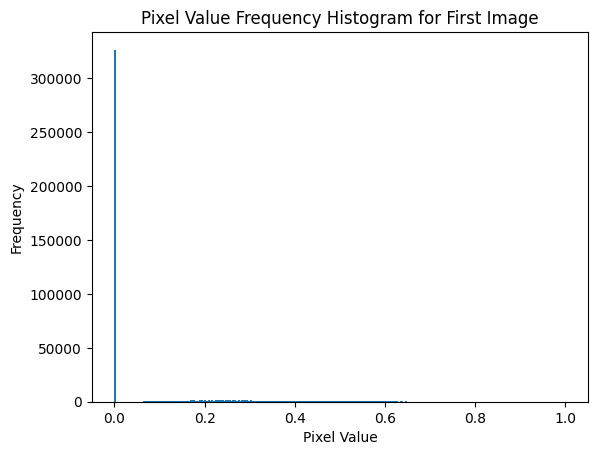

In [18]:
# prompt: pixel value frequency histogram for first image
plt.hist(modis_gpp_clean[0].flatten(), bins=256)
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Pixel Value Frequency Histogram for First Image')
plt.show()


In [20]:
modis_gpp_clean = modis_gpp_clean[1:]
print(len(modis_gpp_clean))

12


# Load and prepare precipitation dataset

In [21]:
def load_modis_climate_images(folder, image_size):
    image_files = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.tif')])
    images = []

    for file in image_files:
        with rasterio.open(file) as src:
            img = src.read(1).astype(np.float32)  # Read first band (grayscale)

            # Mask out values
            mask = img == -3.4028235e+38
            img[mask] = np.nan  # Assign NaN to avoid affecting normalization

            # Resize image
            img = cv2.resize(img, image_size, interpolation=cv2.INTER_NEAREST)

            # Normalize safely (ignoring NaNs)
            img = (img - np.nanmin(img)) / (np.nanmax(img) - np.nanmin(img) + 1e-8)  # Normalize to [0,1]

            # Replace NaNs back with 0 or another suitable value
            img = np.nan_to_num(img, nan=0.0)

            images.append(img)

    return np.array(images)

In [22]:
climate_precip_clean = load_modis_climate_images(climate_precip, image_size)

In [23]:
for img in climate_precip_clean:
    unique_values = np.unique(img)
    print(unique_values)
climate_precip_clean[0].shape

[0.         0.00890193 0.0116504  ... 0.98380333 0.9869163  1.        ]
[0.         0.00487275 0.00526482 ... 0.9876626  0.9924083  1.        ]
[0.         0.00150683 0.00253143 ... 0.9908224  0.9940252  1.        ]
[0.         0.00351318 0.00444608 ... 0.98019266 0.9862252  1.        ]
[0.         0.00180045 0.00285257 ... 0.94493794 0.9463566  1.        ]
[0.         0.0036981  0.00513967 ... 0.96712035 0.9763684  1.        ]
[0.0000000e+00 7.4471789e-04 4.1018785e-03 ... 9.6130824e-01 9.6766520e-01
 1.0000000e+00]
[0.         0.00147752 0.00360123 ... 0.9816501  0.996897   1.        ]
[0.         0.00355801 0.00448173 ... 0.99135333 0.9970347  1.        ]
[0.0000000e+00 7.6539017e-04 1.1657210e-03 ... 9.7549671e-01 9.9499917e-01
 1.0000000e+00]
[0.0000000e+00 5.2039418e-04 1.5560574e-03 ... 9.8760653e-01 9.9995714e-01
 1.0000000e+00]
[0.         0.00282221 0.00359423 ... 0.9665831  0.9708062  1.        ]
[0.         0.00587472 0.00731127 ... 0.9772826  0.98941165 1.        ]
[0.0000

(565, 769)

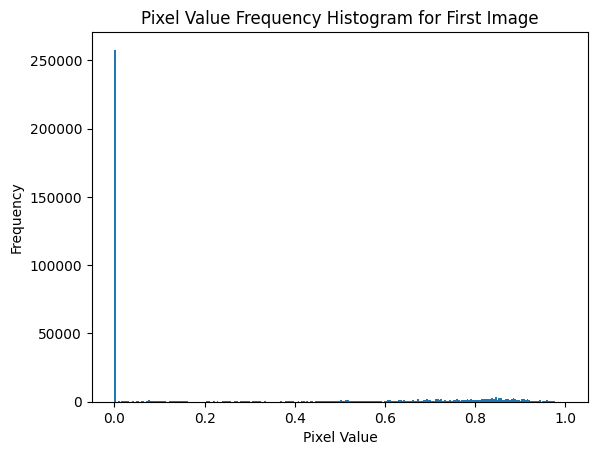

In [8]:
# prompt: pixel value frequency histogram for first image
plt.hist(climate_precip_clean[0].flatten(), bins=256)
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Pixel Value Frequency Histogram for First Image')
plt.show()

In [25]:
climate_precip_clean = climate_precip_clean[1:]
print(len(climate_precip_clean))

12


# CNNLSTM Model

In [29]:
print(len(modis_lcd_clean))
print(len(modis_gpp_clean))
print(len(climate_precip_clean))

12
12
12


In [12]:
# change this to change dataset!
images = climate_precip_clean

In [13]:
time_steps = 3  # Number of past frames used for prediction

# Load images and reshape to (num_samples, time_steps, height, width, channels)
num_samples = images.shape[0] - time_steps

# Create sequences (X: past frames, Y: next frame)
X = np.array([images[i:i+time_steps] for i in range(num_samples)])
Y = np.array([images[i+time_steps] for i in range(num_samples)])

# Add channel dimension
X = X[..., np.newaxis]  # Shape: (num_samples, time_steps, height, width, 1)
Y = Y[..., np.newaxis]  # Shape: (num_samples, height, width, 1)

# Split dataset
split_idx = int(0.8 * num_samples)
X_train, X_test = X[:split_idx], X[split_idx:]
Y_train, Y_test = Y[:split_idx], Y[split_idx:]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (7, 3, 565, 769, 1), Test shape: (2, 3, 565, 769, 1)


In [14]:
# Define input shape (time_steps, height, width, channels)
input_shape = (3, 565, 769, 1)  # Replace num_bands with actual number of channels

inputs = Input(shape=input_shape)

# Add padding='same' to ConvLSTM2D layers
x = ConvLSTM2D(filters=16, kernel_size=(3,3), activation='relu', return_sequences=True, padding='same')(inputs)
x = BatchNormalization()(x)

x = ConvLSTM2D(filters=16, kernel_size=(3,3), activation='relu', return_sequences=False, padding='same')(x)
x = BatchNormalization()(x)

outputs = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 3, 565, 769, 1)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d (ConvLSTM2D)             │ (None, 3, 565, 769, 16)     │           9,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 3, 565, 769, 16)     │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)           │ (None, 565, 769, 16)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 565, 769, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 565, 769, 1)         │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,497 (111.32 KB)

 Trainable params: 28,433 (111.07 KB)

 Non-trainable params: 64 (256.00 B)

In [15]:
history = model.fit(X_train, Y_train, epochs=7, batch_size=4, validation_data=(X_test, Y_test))

Epoch 1/7
2/2 ━━━━━━━━━━━━━━━━━━━━ 26s 11s/step - loss: 0.1047 - val_loss: 0.1747
Epoch 2/7
2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 825ms/step - loss: 0.0944 - val_loss: 0.1726
Epoch 3/7
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.0837 - val_loss: 0.1703
Epoch 4/7
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 853ms/step - loss: 0.0766 - val_loss: 0.1677
Epoch 5/7
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 821ms/step - loss: 0.0724 - val_loss: 0.1649
Epoch 6/7
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 890ms/step - loss: 0.0685 - val_loss: 0.1618
Epoch 7/7
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 854ms/step - loss: 0.0642 - val_loss: 0.1584


# Predict

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


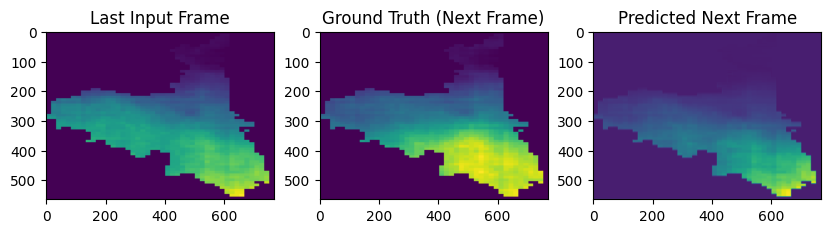

In [16]:
# Make a prediction
idx = np.random.randint(0, len(X_test))
predicted_frame = model.predict(X_test[idx:idx+1])[0, :, :, 0]

# Plot results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Last Input Frame")
plt.imshow(X_test[idx, -1, :, :, 0], cmap='viridis')

plt.subplot(1, 3, 2)
plt.title("Ground Truth (Next Frame)")
plt.imshow(Y_test[idx, :, :, 0], cmap='viridis')

plt.subplot(1, 3, 3)
plt.title("Predicted Next Frame")
plt.imshow(predicted_frame, cmap='viridis')

plt.show()

# Merging the 3 channels and retraining the model

In [35]:
import numpy as np
from tensorflow.keras.layers import Input, ConvLSTM2D, BatchNormalization, Conv2D
from tensorflow.keras.models import Model


print(modis_lcd_clean.shape)
print(modis_gpp_clean.shape)
print(climate_precip_clean.shape)

# Concatenate the datasets along the last axis (channels axis)
images_merged = np.concatenate([modis_lcd_clean[..., np.newaxis], modis_gpp_clean[..., np.newaxis], climate_precip_clean[..., np.newaxis]], axis=-1)

time_steps = 3  # Number of past frames used for prediction

# Now we have 3 channels from each dataset
num_samples = images_merged.shape[0] - time_steps

# Create sequences (X: past frames, Y: next frame)
X = np.array([images_merged[i:i+time_steps] for i in range(num_samples)])
Y = np.array([images_merged[i+time_steps] for i in range(num_samples)])

# Split dataset
split_idx = int(0.8 * num_samples)
X_train, X_test = X[:split_idx], X[split_idx:]
Y_train, Y_test = Y[:split_idx], Y[split_idx:]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

(12, 565, 769)
(12, 565, 769)
(12, 565, 769)
Train shape: (7, 3, 565, 769, 3), Test shape: (2, 3, 565, 769, 3)


In [45]:
# Define input shape (time_steps, height, width, channels)
input_shape = (3, 565, 769, 3)  # 3 time steps, 565x769 spatial dimensions, 3 merged channels

inputs = Input(shape=input_shape)

# Add padding='same' to ConvLSTM2D layers
x = ConvLSTM2D(filters=16, kernel_size=(3,3), activation='relu', return_sequences=True, padding='same')(inputs)
x = BatchNormalization()(x)

x = ConvLSTM2D(filters=16, kernel_size=(3,3), activation='relu', return_sequences=False, padding='same')(x)
x = BatchNormalization()(x)

outputs = Conv2D(filters=3, kernel_size=(1,1), activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 3, 565, 769, 3)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_6 (ConvLSTM2D)           │ (None, 3, 565, 769, 16)     │          11,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 3, 565, 769, 16)     │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_7 (ConvLSTM2D)           │ (None, 565, 769, 16)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 565, 769, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 565, 769, 3)         │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,683 (115.95 KB)

 Trainable params: 29,619 (115.70 KB)

 Non-trainable params: 64 (256.00 B)

In [46]:
history = model.fit(X_train, Y_train, epochs=20, batch_size=4, validation_data=(X_test, Y_test))

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 6s/step - loss: 0.2571 - val_loss: 0.2054
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.1836 - val_loss: 0.2043
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 936ms/step - loss: 0.1372 - val_loss: 0.2033
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 960ms/step - loss: 0.1188 - val_loss: 0.2020
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - loss: 0.1068 - val_loss: 0.2006
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 944ms/step - loss: 0.1000 - val_loss: 0.1992
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 954ms/step - loss: 0.0964 - val_loss: 0.1976
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 954ms/step - loss: 0.0914 - val_loss: 0.1959
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 961ms/step - loss: 0.0891 - val_loss: 0.1942
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 958ms/step - loss: 0.0875 - val_loss: 0.1925
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 959ms/step - loss: 0.0855 - val_loss: 0.1908
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 954ms/step - loss: 0.0827 - val_loss: 0.18

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step
(565, 769, 3)


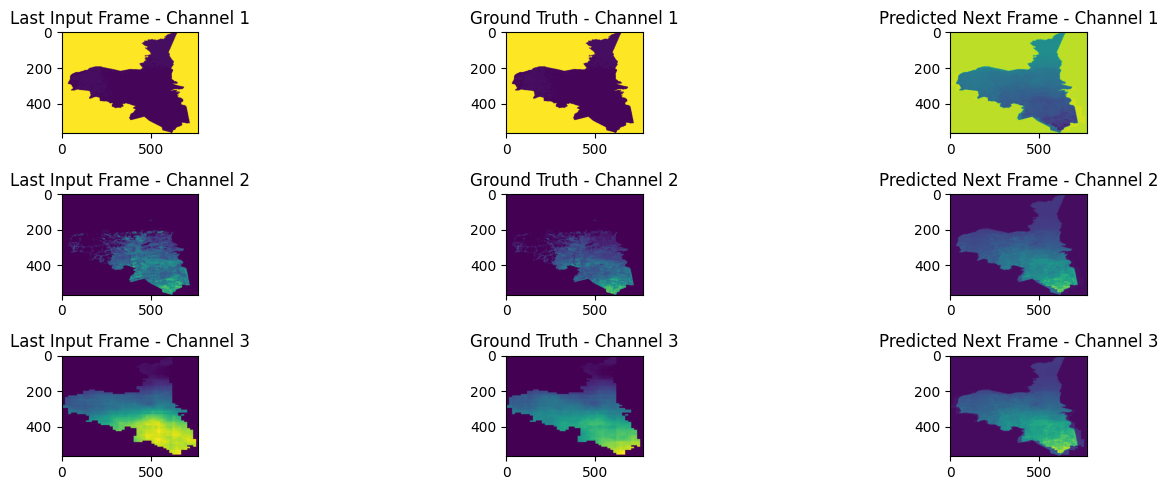

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Make a prediction
idx = np.random.randint(0, len(X_test))  # Random index for testing
predicted_frames = model.predict(X_test[idx:idx+1])[0]  # Predicted next frame for each channel
print(predicted_frames.shape)
# Plot results
plt.figure(figsize=(15, 5))

# Plot each channel for the last input frame, ground truth, and predicted frame
for channel in range(3):
    # Last input frame (from the corresponding channel)
    plt.subplot(3, 3, channel * 3 + 1)
    plt.title(f"Last Input Frame - Channel {channel+1}")
    plt.imshow(X_test[idx, -1, :, :, channel], cmap='viridis')

    # Ground truth frame (from the corresponding channel)
    plt.subplot(3, 3, channel * 3 + 2)
    plt.title(f"Ground Truth - Channel {channel+1}")
    plt.imshow(Y_test[idx, :, :, channel], cmap='viridis')

    # Predicted next frame (from the corresponding channel)
    plt.subplot(3, 3, channel * 3 + 3)
    plt.title(f"Predicted Next Frame - Channel {channel+1}")
    plt.imshow(predicted_frames[:, :, channel], cmap='viridis')

plt.tight_layout()
plt.show()
